In [1]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import deeptensor as dt

In [3]:
np.random.seed(1337)
random.seed(1337)

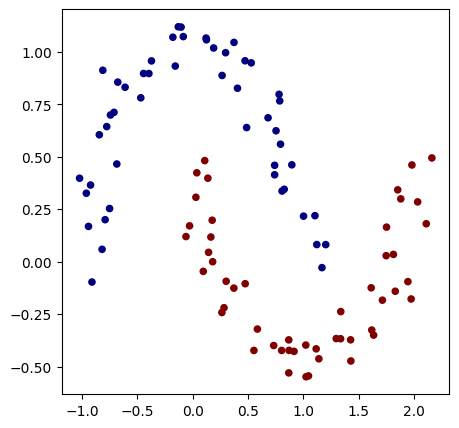

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

# y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [5]:
y

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [6]:
# initialize a model
seed = 42

model = dt.Model(
    [
        dt.LinearLayer(2, 16, seed, "XAVIER", "NORMAL"),
        dt.Sigmoid(),
        dt.LinearLayer(16, 16, seed, "XAVIER", "NORMAL"),
        dt.Sigmoid(),
        dt.LinearLayer(16, 1, seed, "XAVIER", "NORMAL"),
        dt.Sigmoid(),
    ],
    False,  # using_cuda
)

print(model)  # noqa: T201

print("number of parameters", len(model.parameters()))  # noqa: T201


Model(
	LinearLayer(2,16),
	Sigmoid(),
	LinearLayer(16,16),
	Sigmoid(),
	LinearLayer(16,1),
	Sigmoid(),
)
number of parameters 337


In [7]:
opt = dt.Adam(model, 0.001)  # learning rate

In [8]:
avg_loss_progression = []
for epochs in range(50):
    total_loss = 0
    accuracy = 0
    for i in range(len(X)):
        curr_input = dt.Tensor([2])
        for j in range(len(X[i])):
            curr_input.set(j, dt.Value(X[i][j]))

        y_pred = model(curr_input)

        predicted = int(y_pred.get(0).data > 0.5)
        if predicted == y[i]:
            accuracy += 1
        loss = dt.binary_cross_entropy(y_pred, y[i])
        total_loss += loss.data

        # backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        del curr_input

    avg_loss = round(total_loss / len(X), 6)
    avg_loss_progression.append(avg_loss)
    acc_percent = round(((accuracy / len(X)) * 100), 6)
    print("Epoch", epochs, ";\tAvg Loss:", avg_loss, ";\t Accuray: ", acc_percent)  # noqa: T201


Epoch 0 ;	Avg Loss: 0.709918 ;	 Accuray:  50.0
Epoch 1 ;	Avg Loss: 0.690839 ;	 Accuray:  50.0
Epoch 2 ;	Avg Loss: 0.679926 ;	 Accuray:  57.0
Epoch 3 ;	Avg Loss: 0.669258 ;	 Accuray:  77.0
Epoch 4 ;	Avg Loss: 0.656656 ;	 Accuray:  77.0
Epoch 5 ;	Avg Loss: 0.641212 ;	 Accuray:  79.0
Epoch 6 ;	Avg Loss: 0.622454 ;	 Accuray:  80.0
Epoch 7 ;	Avg Loss: 0.600223 ;	 Accuray:  81.0
Epoch 8 ;	Avg Loss: 0.574744 ;	 Accuray:  82.0
Epoch 9 ;	Avg Loss: 0.546732 ;	 Accuray:  82.0
Epoch 10 ;	Avg Loss: 0.517432 ;	 Accuray:  82.0
Epoch 11 ;	Avg Loss: 0.488451 ;	 Accuray:  82.0
Epoch 12 ;	Avg Loss: 0.461336 ;	 Accuray:  83.0
Epoch 13 ;	Avg Loss: 0.437159 ;	 Accuray:  84.0
Epoch 14 ;	Avg Loss: 0.416361 ;	 Accuray:  85.0
Epoch 15 ;	Avg Loss: 0.398885 ;	 Accuray:  85.0
Epoch 16 ;	Avg Loss: 0.384381 ;	 Accuray:  85.0
Epoch 17 ;	Avg Loss: 0.372387 ;	 Accuray:  85.0
Epoch 18 ;	Avg Loss: 0.362439 ;	 Accuray:  85.0
Epoch 19 ;	Avg Loss: 0.354131 ;	 Accuray:  85.0
Epoch 20 ;	Avg Loss: 0.347127 ;	 Accuray:  85.0
Ep

(-1.548639298268643, 1.951360701731357)

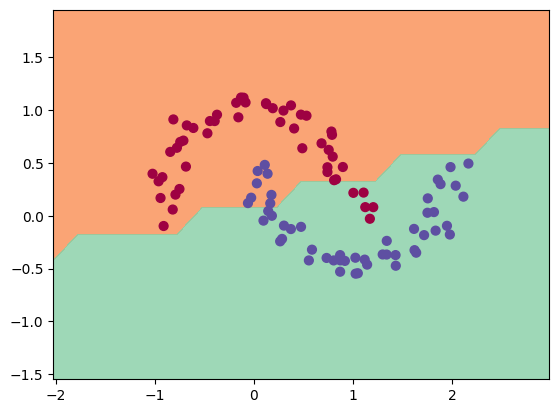

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
# inputs = [list(map(dt.Value, xrow)) for xrow in Xmesh]
inputs = []
for xrow in Xmesh:
    new_inp = dt.Tensor([len(xrow)])
    for idx, _x in enumerate(xrow):
        new_inp.set(idx, dt.Value(_x))
    inputs.append(new_inp)
scores = list(map(model, inputs))
Z = np.array([s.get(0).data > 0.5 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
